In [25]:
import importlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import json
import sys
import statsmodels.api as sm
import os
import kad.visualization.visualization as visualization
from kad.kad_utils.kad_utils import customize_matplotlib
from kad.model.sarima_model import SarimaModel
import kad.models_evaluation.models_evaluator as models_evaluator

sys.path.insert(1, '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector')
print(sys.path)

import kad.ts_analyzer.ts_analyzer as ts_analyzer
from kad.model import i_model
from sklearn.model_selection import train_test_split

customize_matplotlib()

['/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/notebooks', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/venv/lib/python3.8/site-packages', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/venv/lib/python3.8/site-packages/IPython/extensions', '/home/maciek/.ipython', '/snap/pycharm-professional/240/plugins/python/helpers/pydev', '/snap/pycharm-professional/240/plugins/python/helpers-pro/jupyter_debug']


# Reading data

In [14]:
data_dir = "data/archive/"
file_dir = "artificialWithAnomaly"
file_name = "artificialWithAnomaly/art_daily_jumpsup.csv"

file_path = os.path.join(data_dir, file_dir, file_name)

original_df = pd.read_csv(
    file_path, parse_dates=True, index_col="timestamp"
)

original_df = original_df.resample("h").agg(np.mean)

with open("data/archive/combined_windows.json") as f:
    true_anomalies = json.load(f)

# Data preprocessing

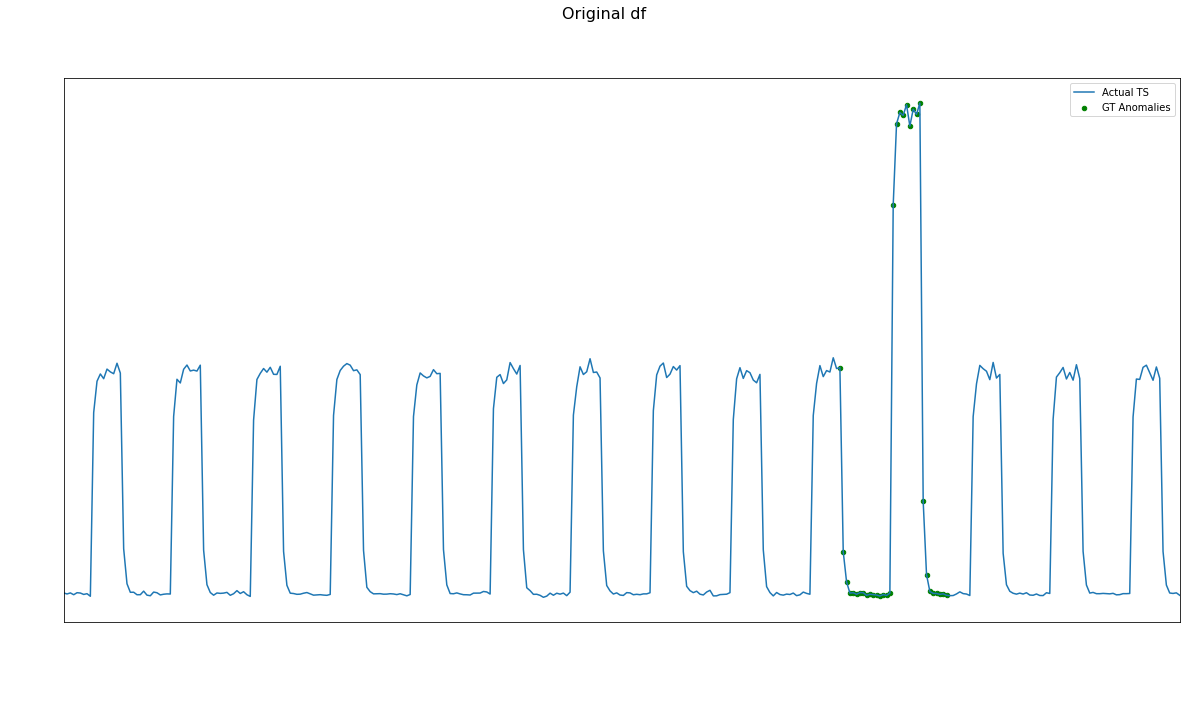

In [15]:
X_LABEL = "timestamp"
ts_analyzer = importlib.reload(ts_analyzer)

true_anomalies_ranges = true_anomalies[file_name]

ground_true_anomalies_df = pd.DataFrame()
for anom_range in true_anomalies_ranges:
    ground_true_anomalies_df = ground_true_anomalies_df.append(original_df.loc[anom_range[0]:anom_range[1]])

preprocessed_df = original_df.copy()
preprocessed_df["gt_is_anomaly"] = [idx in ground_true_anomalies_df.index  for idx in original_df.index.tolist()]

visualization.visualize(results_df=preprocessed_df, metric_name="value", title="Original df")

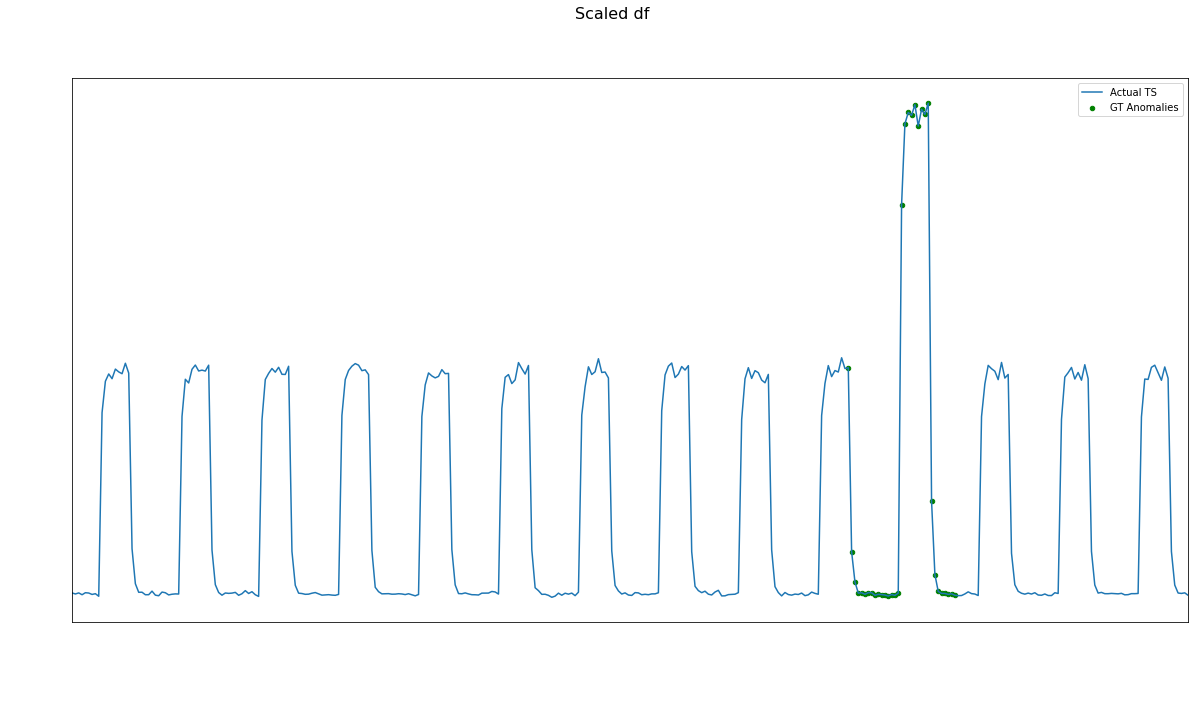

In [16]:
scaler = MinMaxScaler(feature_range=(-1, 0))
preprocessed_df["value"] = scaler.fit_transform(preprocessed_df.values)

visualization.visualize(results_df=preprocessed_df, metric_name="value", title="Scaled df")


In [17]:
values_df = preprocessed_df[["value"]]
tsa = ts_analyzer.TsAnalyzer(values_df)
print("Is TS stationary: ", tsa.is_stationary())


Statistics analysis

Statistic Test :  -8.848107476407737
p-value :  1.600138263816873e-14
# n_lags :  12
No of observation:  323
 critical value 1% : -3.4507587628808922
 critical value 5% : -2.870530068560499
 critical value 10% : -2.5715597727381647
Is TS stationary:  True


/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/venv/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


Text(0.5, 0.98, 'ACF & PACF')

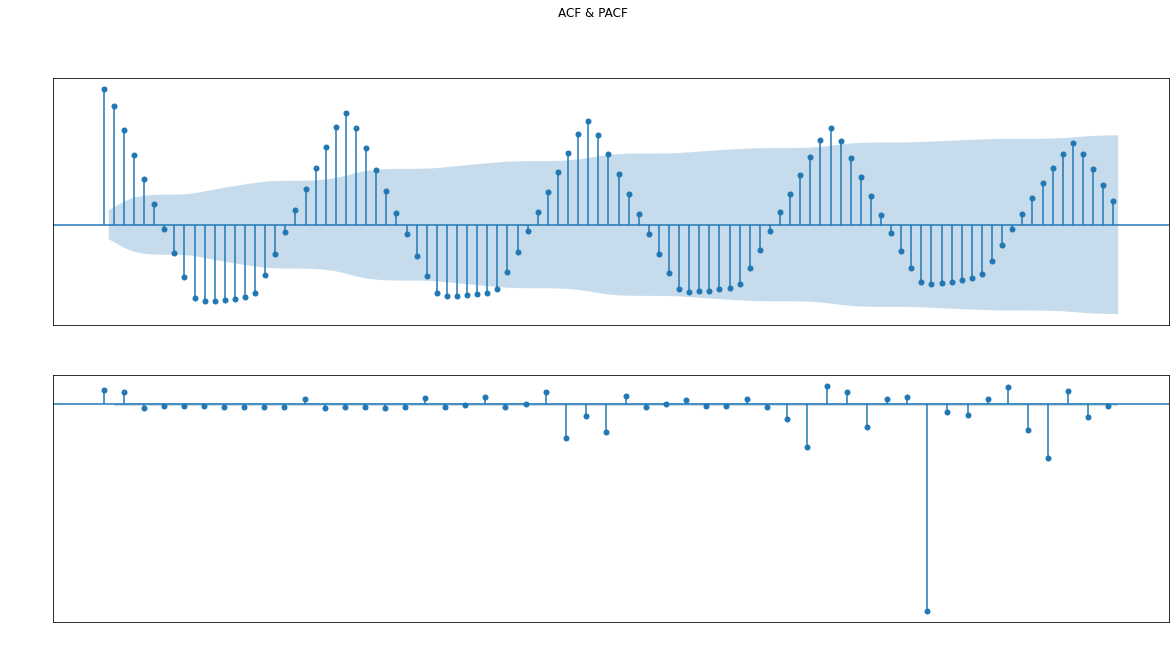

In [18]:
f = plt.figure(figsize=(20, 10))
ax = f.add_subplot(2, 1, 1)
_ = sm.graphics.tsa.plot_acf(values_df, lags=100, ax=ax)
ax2 = f.add_subplot(2, 1, 2)
_ = sm.graphics.tsa.plot_pacf(values_df, lags=50, ax=ax2)
f.suptitle("ACF & PACF")

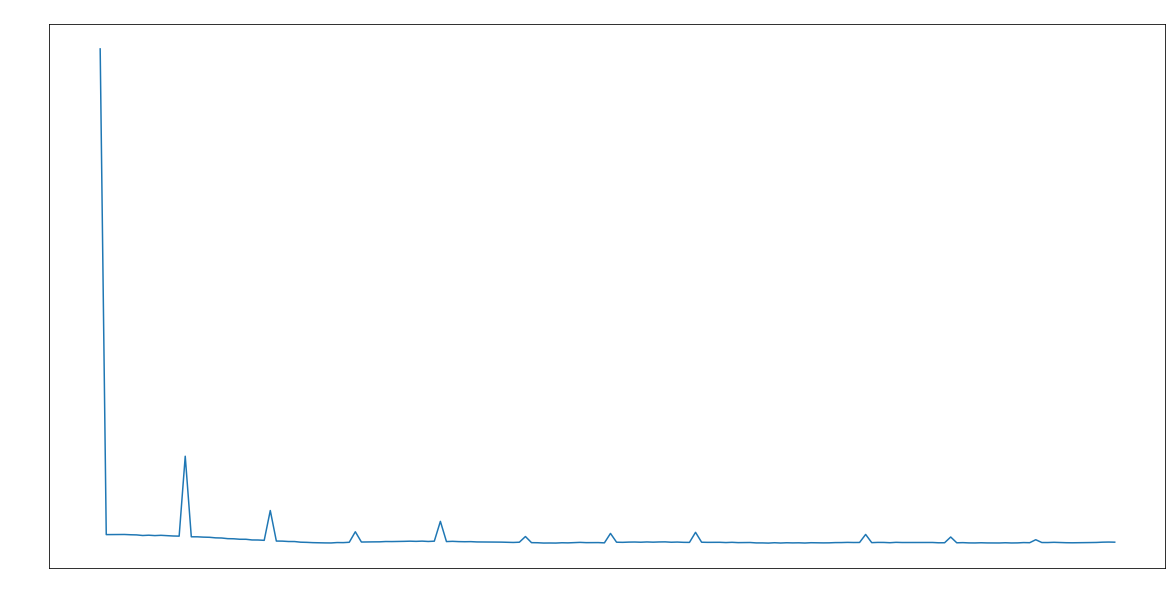

In [19]:
dominant_freq = tsa.calculate_dominant_frequency()

# SARIMA

In [20]:
model: i_model.IModel = SarimaModel(order=(0, 0, 0), seasonal_order=(1, 0, 1, dominant_freq))

In [21]:
train_df, test_df = train_test_split(values_df, shuffle=False, train_size=0.7)
model.train(train_df)

/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


                                 SARIMAX Results                                  
Dep. Variable:                          y   No. Observations:                  164
Model:             SARIMAX(1, 0, [1], 24)   Log Likelihood                 433.885
Date:                    Sat, 17 Apr 2021   AIC                           -861.770
Time:                            11:42:45   BIC                           -852.471
Sample:                                 0   HQIC                          -857.995
                                    - 164                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       0.9999   4.04e-05   2.47e+04      0.000       1.000       1.000
ma.S.L24      54.5779   1.22e-10   4.47e+11      0.000      54.578      54.578
sigma2      2.923e-0

/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/venv/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [22]:
results_df = pd.DataFrame()
SAMPLES_TO_PREDICT = 5
for i in range(0, len(test_df), SAMPLES_TO_PREDICT):
    results_df = model.test(test_df.iloc[i:i+SAMPLES_TO_PREDICT])


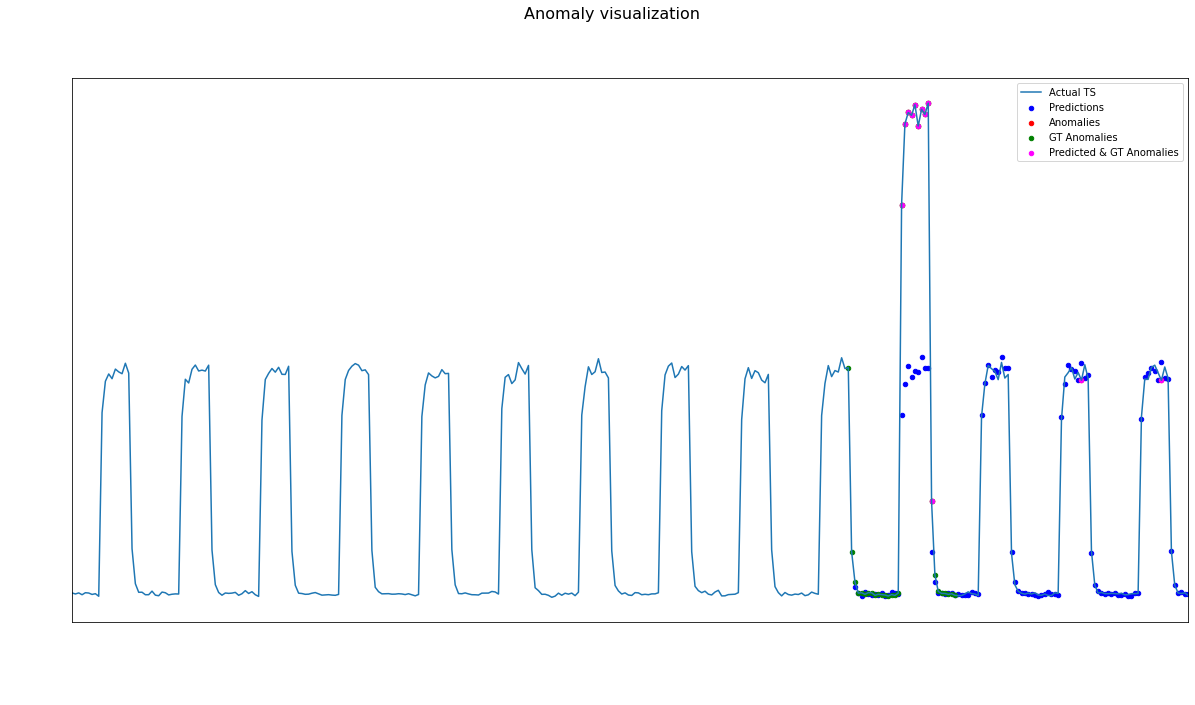

In [23]:
visualization = importlib.reload(visualization)
evaluation_df = results_df.copy()
evaluation_df["gt_is_anomaly"] = preprocessed_df["gt_is_anomaly"]
visualization.visualize(evaluation_df, metric_name="value")

Accuracy:  0.9255952380952381
Avg precision:  0.32097763347763353


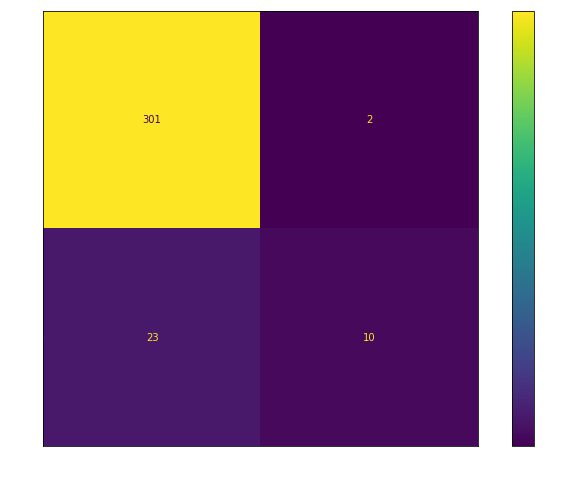

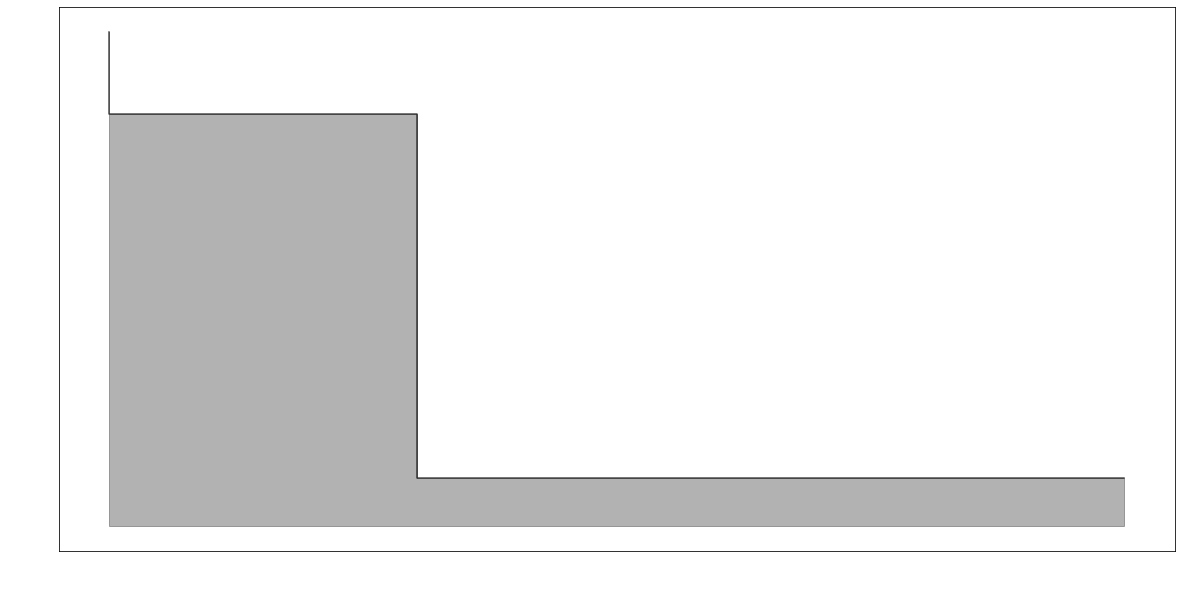

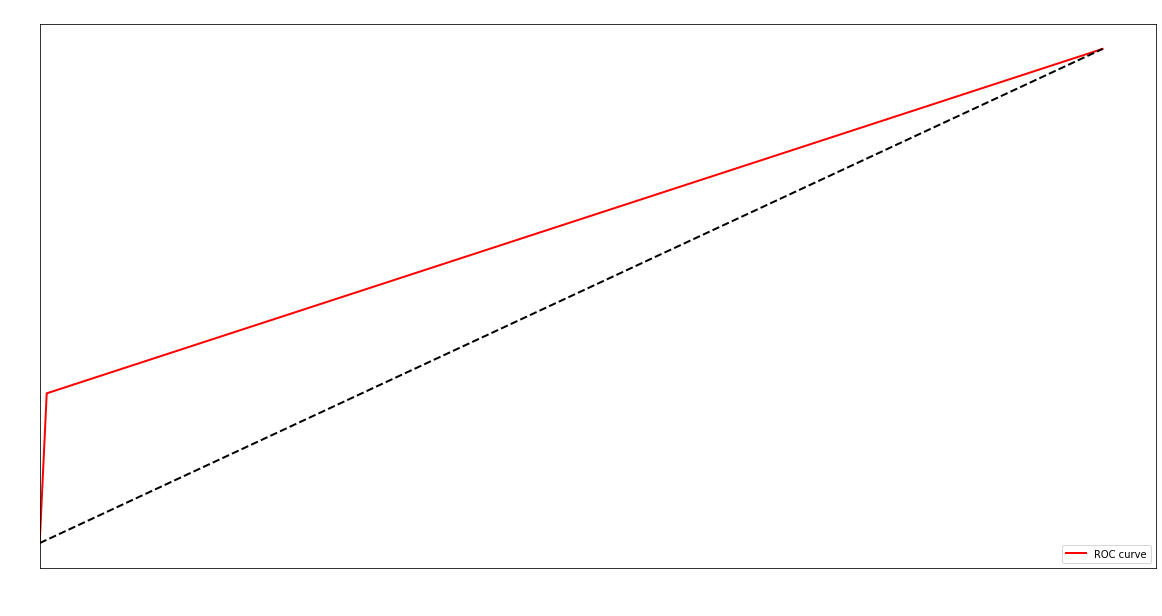

In [26]:
models_evaluator = importlib.reload(models_evaluator)

evaluator = models_evaluator.ModelsEvaluator(df=evaluation_df)

print("Accuracy: ", evaluator.get_accuracy())
print("Avg precision: ", evaluator.get_average_precision())

evaluator.plot_confusion_matrix()


evaluator.plot_precision_recall_curve()
evaluator.plot_roc()

